# Импорт необходимых модулей

In [1]:
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset
import pytorch_lightning as pl
import torch.nn.functional as F
import albumentations as A
import pytorch_lightning_spells as pls
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import sys
import warnings
import timm
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchmetrics import Metric, CharErrorRate
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import models
from efficientnet_pytorch import EfficientNet
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter("ignore", DeprecationWarning)

## Определим конфиг для обучения

In [2]:
cfg = {
    'path_of_data': r'C:\Users\User\Downloads\laba-dataset\samples',
    'train_data': r"C:\Users\User\Downloads\laba-dataset\train",
    'test_data': r"C:\Users\User\Downloads\laba-dataset\test",
    "train_batch_size": 8,
    "test_batch_size": 8,
    'train_workers': 14,
    'test_workers': 2,  
    'epochs': 35,
    'learning_rate': 3e-4,
    'num_gpu': 1,
    'weights_path': r"C:\Users\User\Downloads\laba-dataset\weights",
}

# Подготовка данных

Так как метка изображения у нас изначально представлена в формате "str", то её необходимо преобразовать в вектор.  
Для этого будем использовать энкодер из sklearn (LabelEncoder), обученный на всем наборе каптч

In [3]:
def encode_label(image_relpathes: list) -> list:
    captch_texts = [x.split("\\")[-1].split(".")[0] for x in image_relpathes]
    captcha_tokens = np.array(list(map(lambda str_: list(str_), captch_texts)))
    captcha_alphabet = np.ravel(captcha_tokens) # squeeze
    
    # Encode images
    lbl_enc = LabelEncoder()
    lbl_enc.fit(captcha_alphabet)

    label_enc = np.array([lbl_enc.transform(token) for token in captcha_tokens]) + 1

    return label_enc, lbl_enc

In [4]:
t = os.listdir(cfg['path_of_data'])
labelso, enc = encode_label(t)

In [5]:
enc.classes_

array(['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g',
       'm', 'n', 'p', 'w', 'x', 'y'], dtype='<U1')

In [6]:
class CaptchaDataset(Dataset):
    def __init__(self, 
                 dataset_path: str,
                 transform: bool = None):
        
        self.transform = transform
        self.data_path = dataset_path
        self.image_labels, self.encoder = encode_label(os.listdir(self.data_path))
        self.image_list = os.listdir(self.data_path)
        
    def __read_image(self, img_idx) -> tuple:
        image_path = os.path.join(
            self.data_path,
            self.image_list[img_idx]
        )
        with open(image_path, 'rb') as f:
            nparr = np.frombuffer(f.read(), np.uint8)
            image = cv2.imdecode(nparr, cv2.IMREAD_COLOR) # !!
        
        if self.transform:
            image = self.transform(image=image)['image'] # Albumentation only        
        image_label = self.image_labels[img_idx]
        
        return image, image_label

    def __len__(self) -> int:
        return len(os.listdir(self.data_path))
    
    def __getitem__(self, idx):
        img, lab = self.__read_image(idx)
        return img, lab

Протестируем корректность кода (датасет без учета преобразований)

In [7]:
dataset = CaptchaDataset(dataset_path = cfg['path_of_data'])

In [8]:
data, label = dataset[0]
assert len(dataset) == 1070
#assert isinstance(label, list), f'type of label is {type(label)}'
assert isinstance(data.shape, tuple)
print('OK')

OK


[ 1  1  5 14 10]


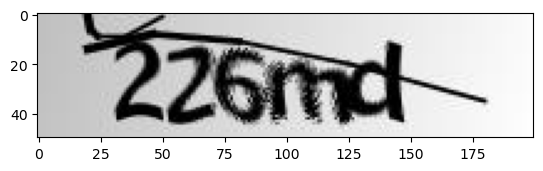

In [9]:
print(label)
plt.imshow(data)

In [10]:
enc.inverse_transform(label - 1)

array(['2', '2', '6', 'm', 'd'], dtype='<U1')

Ниже определим преобразования для датасета и обернем в дата лоадер

In [11]:
train_transform = A.Compose([
    A.GaussNoise(p=0.1),
    A.Normalize(always_apply=True),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(always_apply=True),
    ToTensorV2(),
])

In [12]:
train_dataset = CaptchaDataset(dataset_path = cfg['train_data'], transform=train_transform)
test_dataset = CaptchaDataset(dataset_path = cfg['test_data'], transform=test_transform)

train_dataloader = DataLoader(train_dataset, shuffle=True, pin_memory=True, batch_size=cfg["train_batch_size"],
                              num_workers=0)
test_dataloader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=cfg["test_batch_size"],
                             num_workers=0)

# Создание и обучение модели

Конфигурация архитектуры модели

Была использована предложенная архитетура: Cnn - fc - rnn - fc(output layer)

In [13]:
class Net(nn.Module):
    def __init__(self, num_ch = len(enc.classes_)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d( # Напоминание самому себе, что есть что
            in_channels=3,
            out_channels=256, 
            kernel_size=(3,3), 
            padding=(1,1)
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(256, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.linear1 = nn.Linear(1536, 128)
        self.drop1 = nn.Dropout(0.2)
        
        self.gru = nn.GRU(128, 64,
            bidirectional=True, 
            num_layers=2, 
            dropout=0.15, 
            batch_first=True
        )
        self.out = nn.Linear(128, num_ch + 1)

    def forward(self, x):
        batch_size, _, _, _ = x.size()
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        
        x = x.permute(0, 3, 1, 2)
        x = x.view(batch_size, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)
        
        return x

Доопределим функцию потери и декодирования из выхода модели

In [14]:
def decode_predictions(preds, encoder) -> list:
    preds = torch.softmax(preds.permute(1, 0, 2), 2)
    preds = torch.argmax(preds, 2).detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

In [15]:
def get_loss_function(x, batch_size: int, 
                      labels, 
                      criterion):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(batch_size,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    labels_lengths = torch.full(
        size=(batch_size,), fill_value=labels.size(1), dtype=torch.int32
    )
    

    return criterion(log_softmax_values, labels, input_lengths, labels_lengths)

Пайплайн обучения

In [16]:
class Learner(pl.LightningModule):

    def __init__(
            self,
            learning_rate=cfg['learning_rate'],
            epochs=cfg['epochs'],
    ):
        super().__init__()
        self.save_hyperparameters('learning_rate', 'epochs')
        self.model = Net()
        self.epochs = epochs
        self.loss_f = nn.CTCLoss(blank=0)
        self.train_cer = CharErrorRate()
        self.validate_cer = CharErrorRate()
        
        # logger storages
        self.train_loss = []
        self.validation_cer = []

    def forward(self, x):
        model_output = self.model(x)
        return model_output
    
    @staticmethod
    def __clean(predicted_tokens: list) -> list:
        """
        predicted_tokens: List[str] - decoded model output
        it looks like 
        """
        current, prev = "", ""
        res = ''
        for char in predicted_tokens:
            if char != '-' and char != prev:
                current = char
                res += char
                prev = char
            else:
                prev = ''
                continue

        return res

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
 
        loss = get_loss_function(output, len(y), y, self.loss_f)
        self.train_loss.append(loss)
        
        # metric batch estimation
        preds = decode_predictions(output, enc)        
        for u, v in zip(preds, y.detach().cpu().numpy()):
            real_cap = ''.join(enc.inverse_transform(v - 1))
            pred_cap = self.__clean(u)
            self.train_cer.update(real_cap, pred_cap)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = get_loss_function(output, len(y), y, self.loss_f)
        self.log('validate_loss', loss) # подходил для логирования в wandb/tensorboard. В ноутбуке не используются
        
        preds = decode_predictions(output, enc)        
        for u, v in zip(preds, y.detach().cpu().numpy()):
            real_cap = ''.join(enc.inverse_transform(v - 1))
            pred_cap = self.__clean(u)
            # print(f'real is {real_cap}, pred is {pred_cap}')
            self.validate_cer.update(real_cap, pred_cap)
        return loss

    def training_epoch_end(self, training_step_outputs):
        cer_value  = self.train_cer.compute()
        print(f'training cer is {cer_value}')
        self.train_cer.reset()

    def validation_epoch_end(self, validation_step_outputs):
        cer = self.validate_cer.compute()
        print(f'validation cer is {cer}')
        self.validation_cer.append(cer)
        self.validate_cer.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, factor=0.8, patience=5, verbose=True, 
        )
        return {
           'optimizer': optimizer,
           'scheduler': scheduler,
           'monitor': 'val_loss'
       }
    
    def plot_result(self):
        plt.title(f"Loss train")
        plt.xlabel("batch")
        plt.ylabel("loss")
        print(self.train_loss)
        plt.plot(list(
            map(lambda tens: tens.detach().cpu().numpy(), self.train_loss))
        )
        plt.show()
        
        plt.title(f"Validation CER")
        plt.xlabel("epoch")
        plt.ylabel("CER")
        print(self.validate_cer)
        plt.plot(list(
            map(lambda tens: tens.cpu(), self.validation_cer))
            )
        plt.show()

Запуск обучения

In [17]:
checkpoint_callback_loss = pl.callbacks.ModelCheckpoint(
    monitor='validate_loss',
    dirpath=cfg["weights_path"],
    filename='net_loss',
    save_top_k = 1,
    mode='min',
    save_weights_only = True,
)

In [18]:
learner_cfg = {key: cfg[key] for key in ['learning_rate', "epochs"]}
model = Learner(**learner_cfg)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

if __name__ == '__main__':

    trainer = pl.Trainer(
        gpus=cfg['num_gpu'], num_nodes=1, accelerator='dp', sync_batchnorm=True, auto_lr_find=False,
        callbacks=[checkpoint_callback_loss, lr_monitor],
        max_epochs=cfg["epochs"],
    )

    trainer.tune(model, train_dataloader, test_dataloader)

    trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\anacon\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Users\User\Downloads\laba-dataset\weights exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\anacon\lib\site-packages\pytorch_lightning\core\optimizer.py:380: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  rank_zero_warn(

  | Name         | Type          | Params
-----------------------------------------------
0 | model        | Net           | 650 K 
1 | loss_f       | CTCLoss       | 0     
2 | train_cer    | CharErrorRate | 0     
3 | validate_cer | CharErrorRate | 0     
-----------------------------------------------
650 K     Trainable params
0         Non-trainable params
650 K     Tota

Sanity Checking: 0it [00:00, ?it/s]

D:\anacon\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


validation cer is 0.9813519716262817


D:\anacon\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is 20.88085174560547


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is inf


Validation: 0it [00:00, ?it/s]

validation cer is inf
training cer is 4720.0


Validation: 0it [00:00, ?it/s]

validation cer is 25.66666603088379
training cer is 59.97435760498047


Validation: 0it [00:00, ?it/s]

validation cer is 5.280374050140381
training cer is 10.238532066345215


Validation: 0it [00:00, ?it/s]

validation cer is 4.520325183868408
training cer is 5.728362083435059


Validation: 0it [00:00, ?it/s]

validation cer is 5.865979194641113
training cer is 4.898265838623047


Validation: 0it [00:00, ?it/s]

validation cer is 11.25
training cer is 14.059560775756836


Validation: 0it [00:00, ?it/s]

validation cer is 0.47031962871551514
training cer is 2.2259583473205566


Validation: 0it [00:00, ?it/s]

validation cer is 0.12627986073493958
training cer is 0.21676942706108093


Validation: 0it [00:00, ?it/s]

validation cer is 0.0826306939125061
training cer is 0.08289816975593567


Validation: 0it [00:00, ?it/s]

validation cer is 0.038155801594257355
training cer is 0.05050504952669144


Validation: 0it [00:00, ?it/s]

validation cer is 0.030351437628269196
training cer is 0.03178327530622482


Validation: 0it [00:00, ?it/s]

validation cer is 0.028616853058338165
training cer is 0.019124522805213928


Validation: 0it [00:00, ?it/s]

validation cer is 0.012658228166401386
training cer is 0.011659953743219376


Validation: 0it [00:00, ?it/s]

validation cer is 0.015772869810461998
training cer is 0.006347863003611565


Validation: 0it [00:00, ?it/s]

validation cer is 0.006339144427329302
training cer is 0.0023285350762307644


Validation: 0it [00:00, ?it/s]

validation cer is 0.004746835213154554
training cer is 0.002116850111633539


Validation: 0it [00:00, ?it/s]

validation cer is 0.007886434905230999
training cer is 0.0019047618843615055


Validation: 0it [00:00, ?it/s]

validation cer is 0.004746835213154554
training cer is 0.0014824226964265108


Validation: 0it [00:00, ?it/s]

validation cer is 0.007886434905230999
training cer is 0.001693838625214994


Validation: 0it [00:00, ?it/s]

validation cer is 0.006319115404039621
training cer is 0.0019039559410884976


Validation: 0it [00:00, ?it/s]

validation cer is 0.003169572213664651
training cer is 0.0010586491553112864


# Анализ/ Расчет Метрик

Рассмотрим визуализированный прогресс обучения и результат по выбранной метрике

[tensor(24.7489, device='cuda:0', grad_fn=<MeanBackward0>), tensor(19.1639, device='cuda:0', grad_fn=<MeanBackward0>), tensor(14.6320, device='cuda:0', grad_fn=<MeanBackward0>), tensor(11.8475, device='cuda:0', grad_fn=<MeanBackward0>), tensor(10.0651, device='cuda:0', grad_fn=<MeanBackward0>), tensor(8.7865, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7.9626, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7.2455, device='cuda:0', grad_fn=<MeanBackward0>), tensor(6.5747, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5.9291, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5.4166, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4.9760, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4.7680, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4.3431, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4.2015, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3.9083, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3.7710, device='cuda:0', grad_fn=<MeanBackward0>), tensor(3

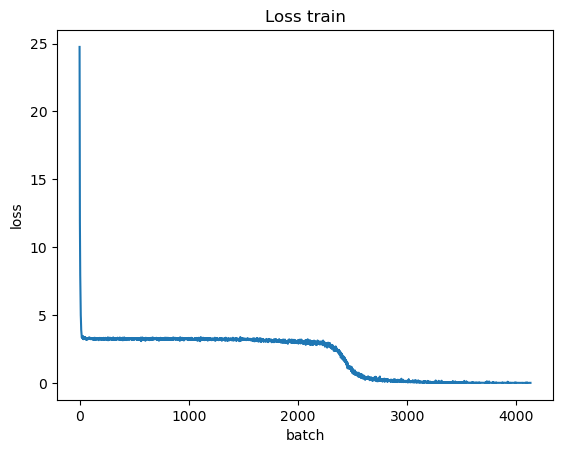

CharErrorRate()


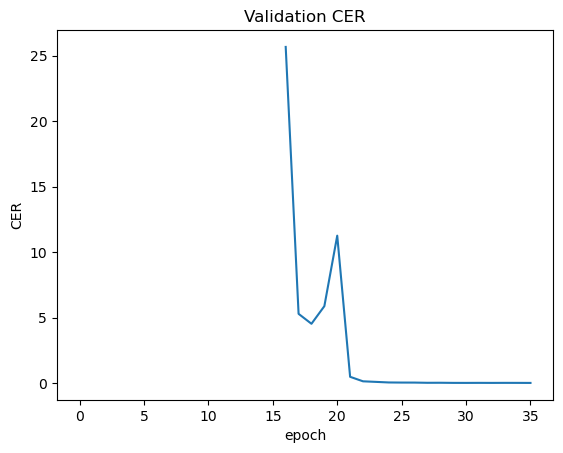

In [19]:
model.plot_result()

Выводы:
1. Считаю наиболее информативным подходам к ошибкам модели смотреть выборку её худших прогнозов. Однако на валидации был получен отличный результат (0.2-0.3% ошибок), так что можно опустить этот этап.
2.  На визуализации выше мы можем наблюдать "необычное" поведение функции ошибок, а именно - плато, где его производная по времени почти нулевая. Все дело в вероятностном подходе, отличном от стандартной оптимизации функции loss, где мы наблюдаем монотонное убывание (если нет переобучения). Незнание возможности видеть подобную картину приводит в замешательство и последующему поиски несуществующей ошибки.   
На этапе отладки заметил, что до выхода из плато модель полностью "слепа". 